In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
#from preprocessing.preprocessing_csv import Preprocessing_CSV_Seniority
#from preprocessing.preprocessing_department_json import Preprocessing_JSON_annotated_Department
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import json
from imblearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap

#### Preprocessing CSV


In [2]:
class Preprocessing_CSV():
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df: pd.DataFrame | None = None

        # Label and Text
        self.X: pd.Series = None
        self.y: pd.Series = None

        # Optional: keep raw versions too
        self.X_raw: pd.Series | None = None
        self.y_raw: pd.Series | None = None

        self.read_csv()

    @staticmethod
    def clean_text(text: str) -> str:
        """Lowercase, strip, replace - and / with spaces."""
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_csv(self):
        """Reads CSV and exposes X (cleaned text) and y (raw text labels)."""
        self.df = pd.read_csv(self.file_path)

        required_cols = {"text", "label"}
        if not required_cols.issubset(self.df.columns):
            raise ValueError("Wrong file mate :( Expected columns: text, label")

        # Raw
        self.X_raw = self.df["text"].astype(str)
        self.y_raw = self.df["label"].astype(str)

        # Cleaned + labels as strings
        self.X = self.X_raw.apply(self.clean_text)
        self.y = self.y_raw

    def label_distribution(self) -> pd.Series:
        """Quick check of label counts."""
        if self.y is None:
            return pd.Series(dtype=int)
        return self.y.value_counts()

#### Pipeline:

1. Load and Prepare CSV Data
2. Load and Prepare not-annotated.json data
3. Concatenate and Train-Test Split
4. Bow and Logistic Regression with Hyperparam Search and 5 Fold CV
5. Test on test set
6. Test on annotated.json -> maybe with .predict_proba()

In [3]:
# 1. Load and Prepare CSV Data
data = Preprocessing_CSV(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/department-v2.csv"
)

X = data.X
y = data.y

In [4]:
# 2. Load and Prepare not-annotated.json Data
not_annotated_data = pd.read_csv(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/labeled_not_annotated.csv"
    )

X_not_annotated = not_annotated_data["position"].astype(str).apply(data.clean_text)
y_not_annotated = not_annotated_data["department"].astype(str)

In [5]:
# 3. Concatenate and Train/Test split
X_concat = pd.concat([X, X_not_annotated], ignore_index=True)
y_concat = pd.concat([y, y_not_annotated], ignore_index=True)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_concat)

print("Combined X:", X_concat.shape)
print("Combined y:", y_encoded.shape)
print("Classes:", encoder.classes_)
print(y_concat.value_counts())

Combined X: (10449,)
Combined y: (10449,)
Classes: ['Administrative' 'Business Development' 'Consulting' 'Customer Support'
 'Human Resources' 'Information Technology' 'Marketing' 'Other'
 'Project Management' 'Purchasing' 'Sales']
Marketing                 4307
Sales                     3351
Information Technology    1327
Business Development       640
Project Management         214
Other                      210
Consulting                 178
Administrative              89
Customer Support            47
Purchasing                  45
Human Resources             41
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y_encoded, test_size=0.2, stratify=y_encoded)

In [7]:
# 4. BOW and Logistic Regression with Hyperparam Search and 5 fold CV

pipe = Pipeline(steps=[
    ("bow", CountVectorizer(ngram_range=(1, 2))),
    ("ros", RandomOverSampler(random_state=123)),
    ("clf", LogisticRegression(max_iter=2000))
])

parameters = {
    "bow__min_df": [1, 2, 3],
    "bow__max_df": [0.9, 0.95, 1.0],
    "clf__C": [0.1, 1, 10],
    "clf__solver": ["liblinear"],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid = GridSearchCV(
    pipe,
    param_grid=parameters,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'bow__max_df': 0.9, 'bow__min_df': 1, 'clf__C': 10, 'clf__class_weight': None, 'clf__solver': 'liblinear'}
Best CV score: 0.8682772918530326


In [8]:
# 5. Test on test-set

csv_prediction = best_model.predict(X_test) # Auch predict_proba() probieren
print("Accuracy:", accuracy_score(y_test, csv_prediction))
print(
    classification_report(
        y_test,
        csv_prediction,
        target_names=encoder.classes_)
)

Accuracy: 0.9574162679425837
                        precision    recall  f1-score   support

        Administrative       0.81      0.72      0.76        18
  Business Development       0.95      0.95      0.95       128
            Consulting       0.85      0.94      0.89        36
      Customer Support       0.75      0.67      0.71         9
       Human Resources       0.88      0.88      0.88         8
Information Technology       0.95      0.94      0.94       265
             Marketing       0.99      0.98      0.99       862
                 Other       0.49      0.93      0.64        42
    Project Management       0.90      0.86      0.88        43
            Purchasing       1.00      0.78      0.88         9
                 Sales       0.99      0.96      0.97       670

              accuracy                           0.96      2090
             macro avg       0.87      0.87      0.86      2090
          weighted avg       0.97      0.96      0.96      2090



In [ ]:
# 6. Test on annotated.json
annotated_json_data = pd.read_csv(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/highest_active_jobs.csv",
)

X_annotated = annotated_json_data["position"].astype(str).apply(data.clean_text)
y_annotated = annotated_json_data["department"].astype(str)

y_annotated_encoded = encoder.transform(y_annotated)

In [10]:
predict_annotated = best_model.predict(X_annotated)

print(f"Accuracy on annotated.json: {accuracy_score(y_annotated_encoded, predict_annotated)}")

print(
    classification_report(
        y_annotated_encoded,
        predict_annotated,
        target_names=encoder.classes_,
        zero_division=0
    )
)

Accuracy on annotated.json: 0.6694560669456067
                        precision    recall  f1-score   support

        Administrative       0.00      0.00      0.00        11
  Business Development       0.26      0.31      0.29        16
            Consulting       0.94      0.57      0.71        30
      Customer Support       1.00      0.20      0.33         5
       Human Resources       0.89      0.57      0.70        14
Information Technology       0.62      0.32      0.42        56
             Marketing       0.50      0.45      0.47        20
                 Other       0.68      0.88      0.76       248
    Project Management       0.61      0.47      0.53        30
            Purchasing       0.67      0.50      0.57        12
                 Sales       0.78      0.69      0.74        36

              accuracy                           0.67       478
             macro avg       0.63      0.45      0.50       478
          weighted avg       0.66      0.67      0.65  

<Figure size 12000x12000 with 0 Axes>

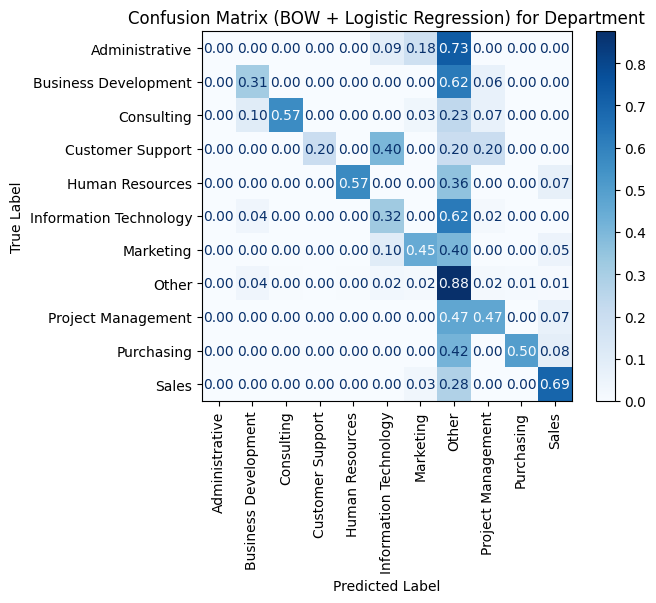

In [11]:
class_names = encoder.classes_

cm_norm = confusion_matrix(
    y_annotated_encoded,
    predict_annotated,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix (BOW + Logistic Regression) for Department")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.tight_layout()
#plt.subplots_adjust(bottom=0.9)
plt.savefig("plots/cm_bow_department.png", bbox_inches="tight")
plt.show()


In [13]:
# 7. Save Model
joblib.dump(best_model, "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/bow_department.joblib")
joblib.dump(encoder, "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_department.joblib")

['/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_department.joblib']

In [14]:
# 8. SHAP Model explanations
bow_model = best_model.named_steps["bow"]
lr_model = best_model.named_steps["clf"]

X_train_vectorized = bow_model.transform(X_train)
X_test_vectorized = bow_model.transform(X_test)

feature_names = bow_model.get_feature_names_out()

random_num_generator = np.random.RandomState(123)
background_idx = random_num_generator.choice(X_train_vectorized.shape[0], size=min(500, X_train_vectorized.shape[0]), replace=False)
X_background = X_train_vectorized[background_idx]

explainer = shap.LinearExplainer(lr_model, X_background, feature_names=feature_names)

n_explain = min(200, X_test_vectorized.shape[0])
X_explain = X_test_vectorized[:n_explain]
shap_values = explainer(X_explain)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10]


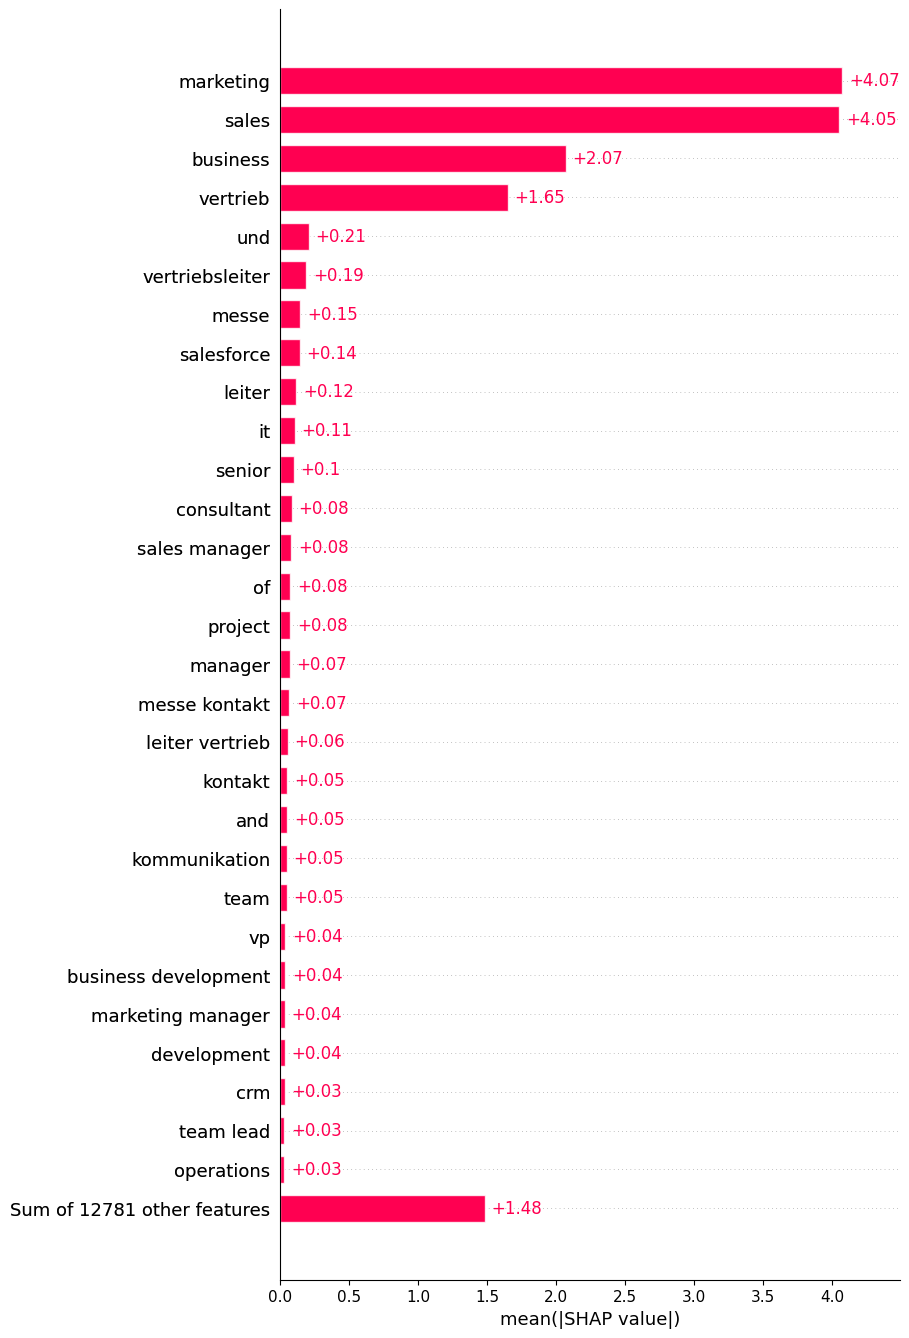

In [ ]:
print("Classes:", lr_model.classes_)

# Only Shows for one class. Change class_name to plot for a different
class_name = lr_model.classes_[1]
class_id = list(lr_model.classes_).index(class_name)

shap_values_class = shap.Explanation(
    values=shap_values.values[:, :, class_id],
    base_values=np.array(shap_values.base_values)[:, class_id],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

shap.plots.bar(shap_values_class, max_display=30)
plt.show()

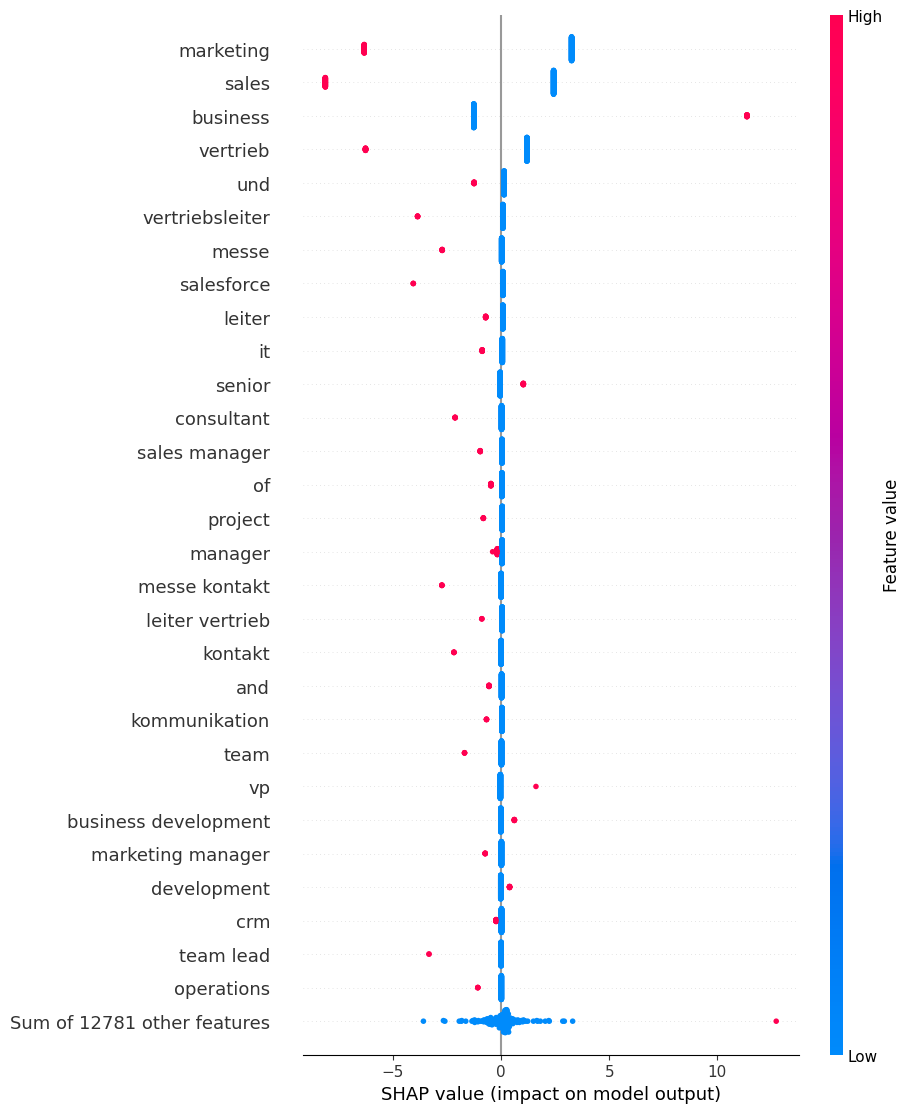

In [16]:
shap.plots.beeswarm(shap_values_class, max_display=30)
plt.show()

Waterfall explanation for class: 1


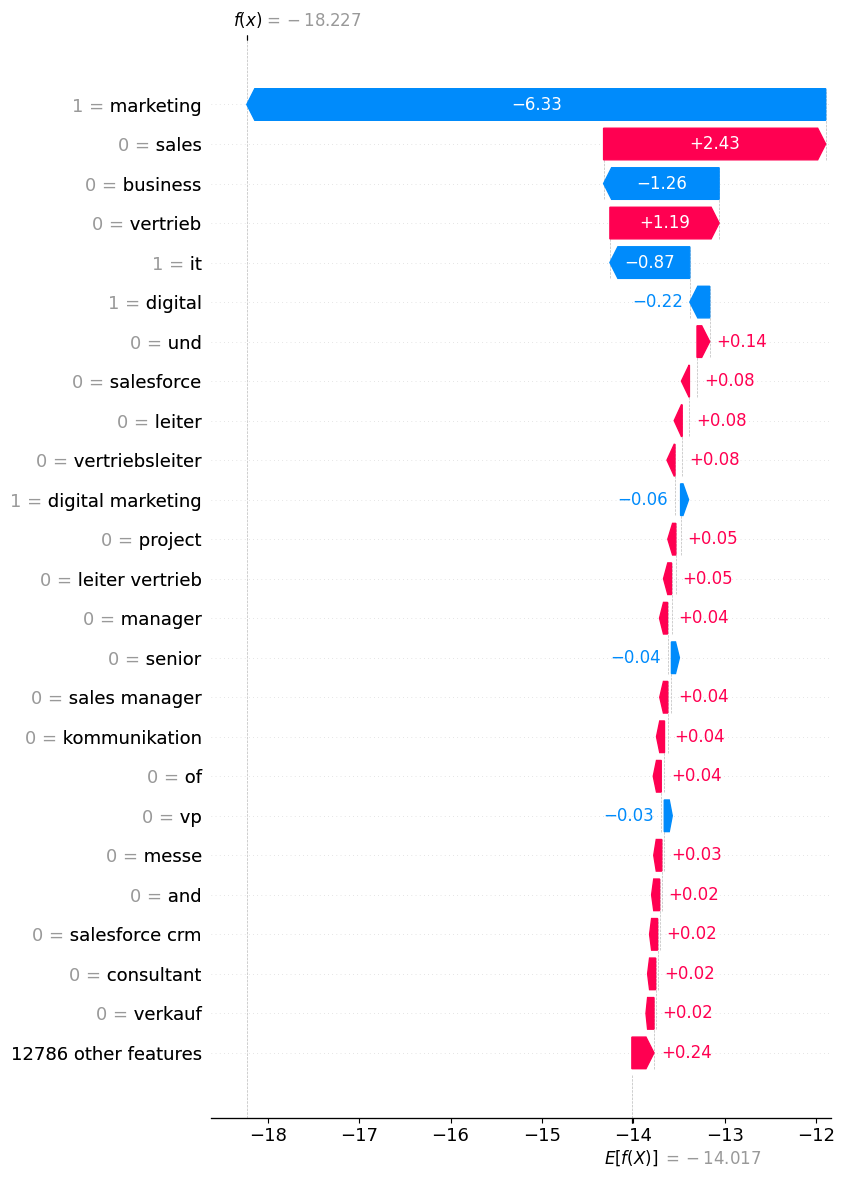

In [17]:
i = 195 # Feature

x_row = X_explain[i].toarray().ravel()

sv_i = shap.Explanation(
    values=shap_values.values[i, :, class_id],
    base_values=np.array(shap_values.base_values)[i, class_id],
    data=x_row,
    feature_names=shap_values.feature_names
)

print("Waterfall explanation for class:", class_name)
shap.plots.waterfall(sv_i, max_display=25)
plt.show()